# Example 2: Using deep_inv_opt with multiple target points from a parametric linear program

In [1]:
# Copyright (C) to Yingcong Tan, Andrew Delong, Daria Terekhov. All Rights Reserved.

import numpy as np
import deep_inv_opt as io
import deep_inv_opt.plot as iop

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.max_open_warning'] = 0  # Let the plots flow!
%matplotlib inline

### Define a parametric linear program with 1-dimensional feature vector *u* and 1-dimensional weight vector *w*

In [6]:
import torch

class ExamplePLP(io.ParametricLP):
    
    # Generate an LP from a given feature vector u and weight vector w.
    def generate(self, u, w):
        c = [[torch.cos(w + u**2 / 2)],
             [torch.sin(w + u**2 / 2)]]

        A_ub = [[-1.0,  0.0],      # x1 >= 0
                [ 0.0, -1.0],      # x2 >= 0
                [ 1.0,  0.0],      # x1 <= 2*w
                [ .5*w, w]]  # (1+w)*x1 + 2*(1+w)*x2 <= u

        b_ub = [[ 0.0],
                [ 0.0],
                [ 4/u],
                [   u]]
        
        return c, A_ub, b_ub, None, None

# Evaluate the parametric LP at specific values of u
u_train = io.tensor(np.linspace(0.5, 2.5, 8).reshape((-1, 1)))


In [7]:
u_train

tensor([[0.5000],
        [0.7857],
        [1.0714],
        [1.3571],
        [1.6429],
        [1.9286],
        [2.2143],
        [2.5000]], dtype=torch.float64)

In [ ]:

# Plot it 
xylim = ((-1, 6), (-1, 6))
cxy = (5, 5)
plt.figure(figsize=(16,4))
for i, w in enumerate([0.5, 1.0, 1.5, 2.0]):
    plt.subplot(141+i)
    plt.title('w=%.1f' % w)
    iop.plot_parametric_linprog(ExamplePLP(weights=[w]), u_train, xylim=xylim, cxy=cxy, show_solutions=True)

### Define `plp_true` with an unknown parameter *w=0.8*, from which we will  generate training data
The arrows are the *c*-vector for different values of *u*, corresponding to the different feasible regions. The solution to each linear program is shown as a circle.

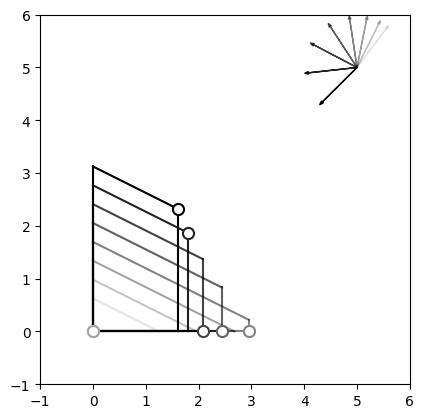

In [3]:
# Create an instance with weight initialized to 0.8, and plot it.
plp_true = ExamplePLP(weights=[0.8])
iop.plot_parametric_linprog(plp_true, u_train, xylim=xylim, cxy=cxy, show_solutions=True)

# Generate training targets by solve the true PLP at each u value.
x_train = torch.cat([io.linprog(*plp_true(ui)).detach().t() for ui in u_train])

### Define `plp_learn` with an initial guess of *w=2.5*, from which we will begin gradient-based learning.
First we plot the training targets as black circles, to highlight the discrepancy between the training targets and the solutions we're currently generating with *w=2.5* (the blue circles).

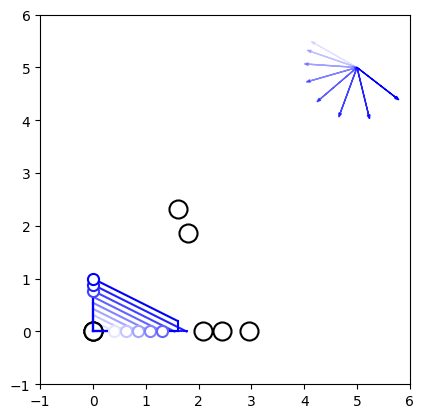

In [4]:
plp_learn = ExamplePLP([2.5])
iop.plot_targets(x_train, markersize=13)
iop.plot_parametric_linprog(plp_learn, u_train, color=[0, 0, 1], xylim=xylim, cxy=cxy, show_solutions=True)

### Train the weight *w* of `plp_learn` in order to better fit the observed targets.
At each step we print both the loss and the current weight (which should converge to 0.8). Finally we plot the learned parametric LP to show that the new solutions (blue circles) line up with the observed targets (black circles).

inverse_parametric_linprog[0001]: loss=2.430563 weights=[2.5000]
inverse_parametric_linprog[0002]: loss=1.658443 weights=[0.5986]
inverse_parametric_linprog[0003]: loss=1.312659 weights=[1.7462]
inverse_parametric_linprog[0004]: loss=0.663341 weights=[1.0899]
inverse_parametric_linprog[0005]: loss=0.040717 weights=[0.7037]
inverse_parametric_linprog[0006]: loss=0.008567 weights=[0.8535]
inverse_parametric_linprog[0007]: loss=0.006104 weights=[0.7598]
inverse_parametric_linprog[0008]: loss=0.000313 weights=[0.8097]
inverse_parametric_linprog[0009]: loss=0.000000 weights=[0.7998]
inverse_parametric_linprog[0010]: loss=0.000000 weights=[0.8000]
inverse_parametric_linprog[done]: loss=0.000000 weights=[0.8000]


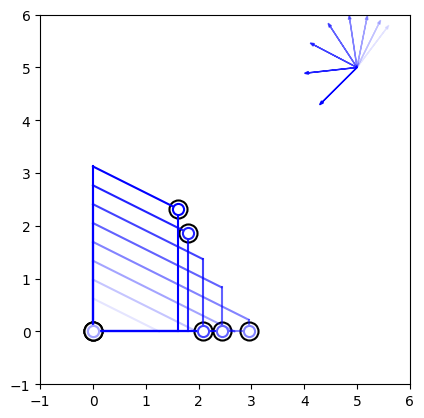

In [5]:
# Adjust weights of plp_learn to fit the training targets
io.inverse_parametric_linprog(u_train, x_train, plp_learn, max_steps=10,
                              callback=io.inverse_parametric_linprog_step_printer())

# Plot the new plp_learn, to show that the solutions (blue circles) now line up with the observed targets (black circles).
iop.plot_targets(x_train, markersize=13)
iop.plot_parametric_linprog(plp_learn, u_train, color=[0, 0, 1], xylim=xylim, cxy=cxy, show_solutions=True)